In [1]:
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

In [3]:
file_path = '../input/sentiment140/training.1600000.processed.noemoticon.csv'

In [4]:
dataset = pd.read_csv(file_path, encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [5]:
dataset.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
dataset = dataset[['sentiment' , 'text']]

In [7]:
dataset.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


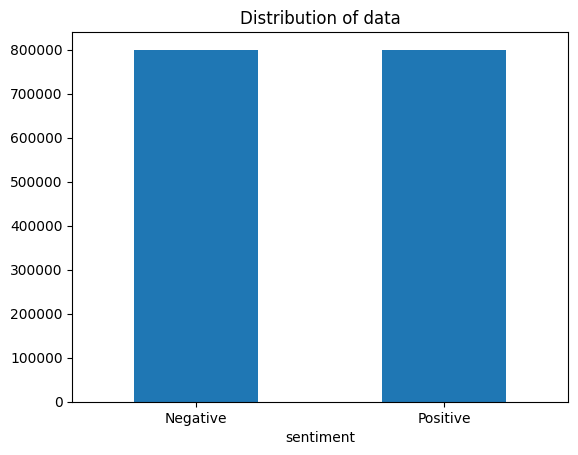

In [8]:
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)


In [9]:
# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1+"
seqReplacePattern = r"\1\1"


def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [10]:
dataset['processed_text'] = dataset.text.apply(preprocess_apply)

In [11]:
count=0
for row in dataset.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break

Text: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Processed: <user> <url> - aww, that's a bummer.  you shoulda got david carr of third day to do it. ;d
Text: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Processed: is upset that he can't update his facebook by texting it.. and might cry as a result  school today also. blah!
Text: @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
Processed: <user> i dived many times for the ball. managed to save 50%  the rest go out of bounds
Text: my whole body feels itchy and like its on fire 
Processed: my whole body feels itchy and like its on fire 
Text: @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
Processed: <user> no, it's not behaving at all. i'm mad. why am i here? because i can't see you all over there.

In [12]:
processedtext = list(dataset['processed_text'])
data_pos = processedtext[800000:]
data_neg = processedtext[:800000]

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

y_data = np.where(y_data == 4, 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done.')

Data Split done.


In [15]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [16]:
# Defining the model and training it.
word2vec_model = Word2Vec(
    sentences=Word2vec_train_data,  # The tokenized training data
    vector_size=Embedding_dimensions,  # Size of the embedding vectors
    window=4,  # Maximum distance between the current and predicted word within a sentence
    min_count=6,  # Ignores all words with total frequency lower than this
    workers=10,  # Number of CPU cores to use for training
    sg=0  # Use Skip-Gram model (sg=1), or CBOW model (sg=0)
)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 76830


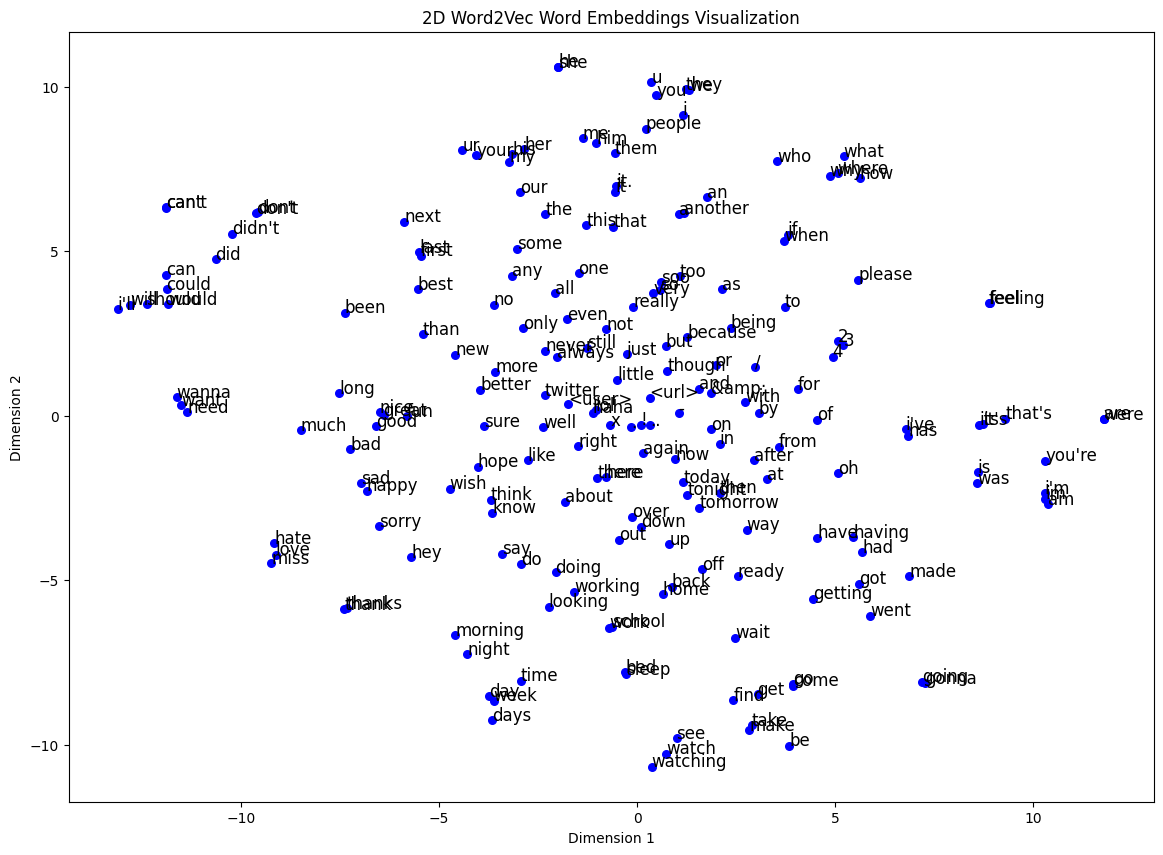

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np


word_vectors = word2vec_model.wv
words = list(word_vectors.key_to_index.keys())  
words_subset = words[:200]  
word_vecs_subset = np.array([word_vectors[word] for word in words_subset])


tsne_model = TSNE(n_components=2, random_state=42, perplexity=40)
word_vecs_2d = tsne_model.fit_transform(word_vecs_subset)


plt.figure(figsize=(14, 10))
plt.scatter(word_vecs_2d[:, 0], word_vecs_2d[:, 1], s=30, c='blue')


for i, word in enumerate(words_subset):
    plt.annotate(word, xy=(word_vecs_2d[i, 0], word_vecs_2d[i, 1]), fontsize=12)

plt.title('2D Word2Vec Word Embeddings Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


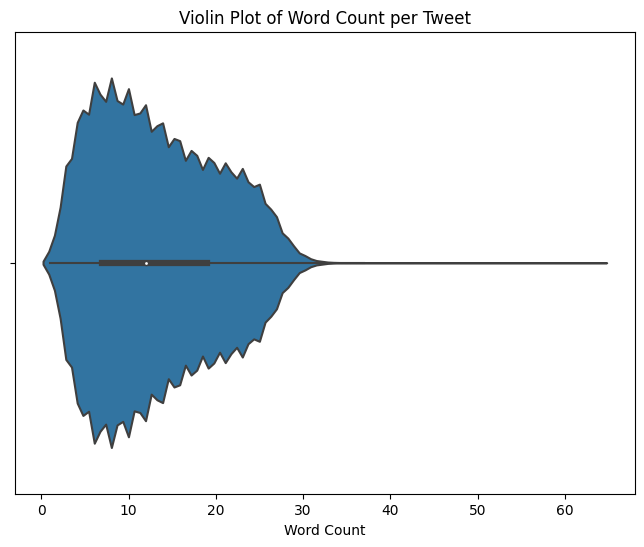

In [18]:
dataset['word_count'] =dataset['processed_text'].apply(lambda x: len(str(x).split()))

# Calculate the statistics
plt.figure(figsize=(8, 6))
sns.violinplot(x=dataset['word_count'])
plt.title('Violin Plot of Word Count per Tweet')
plt.xlabel('Word Count')
plt.show()

In [19]:
input_length = 30

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2024-10-06 12:57:38.599650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 12:57:38.599705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 12:57:38.601226: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [20]:
vocab_length = 75000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 75000


In [21]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (1520000, 30)
X_test.shape : (80000, 30)


In [22]:
print(y_train.shape)
print(y_test.shape)

(1520000,)
(80000,)


In [23]:
filtered_word_index = {word: token for word, token in tokenizer.word_index.items() if token <= vocab_length}

In [24]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in filtered_word_index.items():
    if word in word2vec_model.wv and token < vocab_length:
        embedding_matrix[token] = word2vec_model.wv[word]

print("Embedding Matrix Shape:", embedding_matrix.shape)


Embedding Matrix Shape: (75000, 100)


In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding , GRU , LayerNormalization , Dropout
from tensorflow.keras.regularizers import l2

In [ ]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [ ]:
# Custom Attention Layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = Dense(units)
        self.U = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W(features) + self.U(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

# Functional API model
def getModel():
    input_tensor = Input(shape=(input_length,))

    # Embedding Layer
    embedding_layer = Embedding(input_dim=vocab_length,
                                output_dim=Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)(input_tensor)

    # BiLSTM layers
    lstm_out1 = Bidirectional(LSTM(100, recurrent_dropout=0.2,return_sequences=True))(embedding_layer)
    lstm_out2 = Bidirectional(LSTM(100, recurrent_dropout=0.2, return_sequences=True))(lstm_out1)
    
    # GRU Layers
    GRU(100, dropout=0.1, return_sequences=True),

    # Attention mechanism
    attention_layer = Attention(100)
    context_vector, _ = attention_layer(lstm_out2, lstm_out2[:, -1])

    # Fully connected layers
    dense_out = Dense(16, activation='relu')(context_vector)
    output = Dense(1, activation='sigmoid')(dense_out)

    # Model
    model = tf.keras.models.Model(inputs=input_tensor, outputs=output, name="Sentiment_Model_with_Attention")
    return model


In [36]:
def getModel():
    embedding_layer = Embedding(input_dim=vocab_length,
                                output_dim=Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, return_sequences=True)),
        Bidirectional(LSTM(100, recurrent_dropout=0.3, return_sequences=False)),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model


In [37]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     7,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,500,000 (28.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,500,000 (28.61 MB)

In [38]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=2, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [39]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
from tensorflow.keras.optimizers import Nadam

# Compile the model with Nadam optimizer
training_model.compile(
    loss='binary_crossentropy', 
    optimizer=Nadam(learning_rate=0.001),  # You can adjust the learning rate if needed
    metrics=['accuracy']
)

In [48]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=5,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/5
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 114s 82ms/step - accuracy: 0.8486 - loss: 0.3416 - val_accuracy: 0.8377 - val_loss: 0.3632 - learning_rate: 0.0010
Epoch 2/5
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 108s 81ms/step - accuracy: 0.8536 - loss: 0.3318 - val_accuracy: 0.8389 - val_loss: 0.3621 - learning_rate: 0.0010
Epoch 3/5
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 108s 81ms/step - accuracy: 0.8583 - loss: 0.3233 - val_accuracy: 0.8387 - val_loss: 0.3654 - learning_rate: 0.0010
Epoch 4/5
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 109s 81ms/step - accuracy: 0.8622 - loss: 0.3150 - val_accuracy: 0.8387 - val_loss: 0.3672 - learning_rate: 0.0010
Epoch 5/5
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 109s 81ms/step - accuracy: 0.8708 - loss: 0.2983 - val_accuracy: 0.8380 - val_loss: 0.3715 - learning_rate: 1.0000e-04


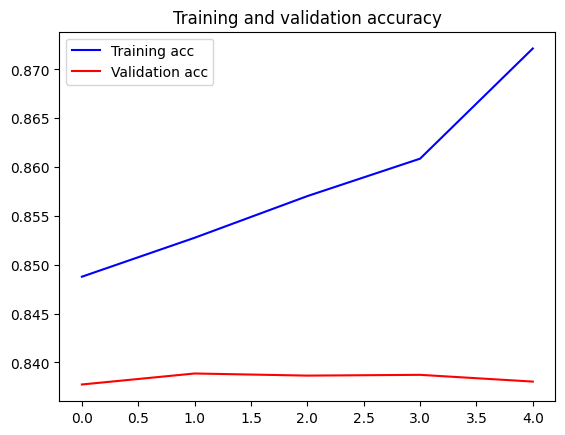

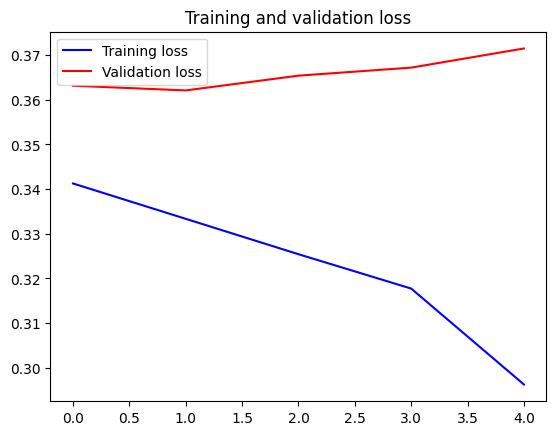

In [49]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [50]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step


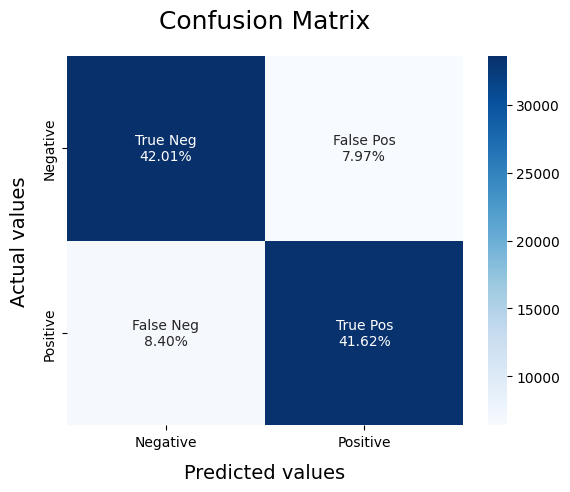

In [51]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

In [52]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84     39989
           1       0.84      0.83      0.84     40011

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000



In [ ]:
# Saving Word2Vec-Model
word2vec_model.wv.save('Word2Vec-twitter-100')
word2vec_model.wv.save_word2vec_format('Word2Vec-twitter-100-trainable')

# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the TF-Model.
training_model.save('Sentiment-BiLSTM.h5')

# Saving the model weights with the required extension
training_model.save_weights('weights.weights.h5') 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle
import numpy as np

In [ ]:
with open('/kaggle/working/Tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Step 2: Load the model
model = load_model('/kaggle/working/Sentiment-BiLSTM.h5')

# Step 3: Prepare your input text
text = ["Today is not a great day!"]
sequences = tokenizer.texts_to_sequences(text)
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=60)  # Adjust maxlen to match your training

# Step 4: Predict the sentiment
prediction = model.predict(padded_sequences)

# Step 5: Interpret the prediction
sentiment = np.argmax(prediction, axis=1)
if sentiment == 0:
    print("Negative Sentiment")
elif sentiment == 1:
    print("Positive sentiment")